In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./dgmr')
import dgmr


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [7]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

_MEDIAN_PIXEL = 212.0
_IQR = 213.0

def transform(x):
    return np.tanh((x - _MEDIAN_PIXEL) / _IQR)

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index+12-INPUT_STEPS:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        x = transform(x)
        y = transform(y)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [8]:
x, y = ds[0]

In [9]:
x.shape, y.shape

((4, 128, 128), (24, 64, 64))

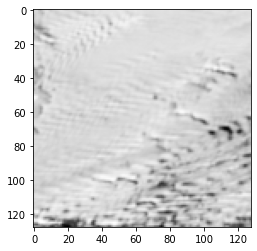

In [11]:
plt.imshow(x[-1], cmap='gray')

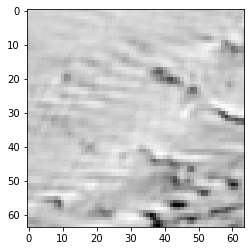

In [12]:
plt.imshow(y[0], cmap='gray')

In [13]:
model = dgmr.DGMR(
    forecast_steps=FORECAST,
    input_channels=1,
    output_shape=128,
    latent_channels=384,
    context_channels=192,
    num_samples=3,
)
model = model.to(DEVICE)
model.load_state_dict(torch.load('weights/300d_dgmr/dgmr_epochs=6_loss=0.0471.pt'))

<All keys matched successfully>

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 58104267 trainable parameters


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_criterion = torch.nn.MSELoss()

In [18]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    final_layer = torch.nn.AvgPool2d(kernel_size=2)

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)

        preds = model(x)
        b, t, c, h, w = preds.shape
        preds = preds.reshape(b, t*c, h, w)
        preds = final_layer(preds)
        preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
        preds = torch.tanh(preds)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 300 == 299:
                torch.save(model.state_dict(), f'weights/300d_dgmr/dgmr_epochs={epoch}_batch={i}_loss={avg_loss}.pt')

    return epoch_loss / total_count



In [ ]:
EPOCHS = 100
EXISTING = 6

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, mse_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/300d_dgmr/dgmr_epochs={i}_loss={avg_loss}.pt')
    

Epoch 7


  0%|          | 0/1145 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.046, 0.0403): 100%|██████████| 1145/1145 [54:05<00:00,  2.83s/it] 


Epoch 8


Avg Loss, Batch Loss: (0.0455, 0.0542): 100%|██████████| 1145/1145 [54:18<00:00,  2.85s/it]


Epoch 9


Avg Loss, Batch Loss: (0.0449, 0.0552):  83%|████████▎ | 945/1145 [45:54<09:31,  2.86s/it]  

In [120]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [124]:
LOOKS = 500

In [123]:
final_layer = torch.nn.AvgPool2d(kernel_size=2)
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.float().to(DEVICE)
    y = trgs.float().to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
        
    b, t, c, h, w = preds.shape
    preds = preds.reshape(b, t*c, h, w)
    preds = final_layer(preds)
    preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
    preds = torch.tanh(preds)
    
    y = torch.atanh(y) * _IQR + _MEDIAN_PIXEL
    preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')
    

  0%|          | 0/1145 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Score: 0.6972056823525636:  45%|████▍     | 511/1145 [03:16<04:03,  2.60it/s]


KeyboardInterrupt: 

In [127]:
scores = np.array(scores)
scores.mean()

0.6972056823525643

In [134]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.76427048, 0.75715009, 0.74652838, 0.73532941, 0.72486059,
       0.7156511 , 0.70795827, 0.7013266 , 0.69587604, 0.69121912,
       0.68715448, 0.68395004, 0.68148806, 0.67939699, 0.67778978,
       0.67656015, 0.67569989, 0.67522374, 0.67507794, 0.67497855,
       0.67530662, 0.67597359, 0.67666508, 0.6775014 ])

In [132]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [142]:
choice = 6
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.7181337909387026

In [ ]:
plt.imshow(out[0,-1], cmap='gray')

In [ ]:
plt.imshow(true[0,-1], cmap='gray')